# Gradient Domain Blending

In image blending, we want to create an output image from the composition of two different and separate images. The ultimate goal is to seamlessly incorporate and blend an object from the source image onto a target image. Using a simple copy-paste technique, or alpha blending, we would achieve non-ideal results. The regions of the source image bordering the region of the target image would be too obvious to the human eye, due to the drastic changes in image intensity.
<br>

We resort to gradient domain blending for this segment of the project. The gradients capture properties of an image, including shape, shading, texture, and illumination. We work with the gradients to preserve these features from the source image and to effectively blend the source image region onto the target image. The output image will appear more natural compared to the result from alpha blending, because we blend the gradients to ensure features are integrated smoothly.


# Import & Setting Up

In [1]:
# import packages 

import scipy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import scipy.signal as signal
from google.colab import files

# opencv
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/CIS-5810-Final-Project/Work/Jeff/seamless

/content/drive/MyDrive/CIS-5810-Final-Project/Work/Jeff/seamless


## Initial Images

In [4]:
src = cv2.imread('Images/source.jpg')
target = cv2.imread('Images/target.jpg')

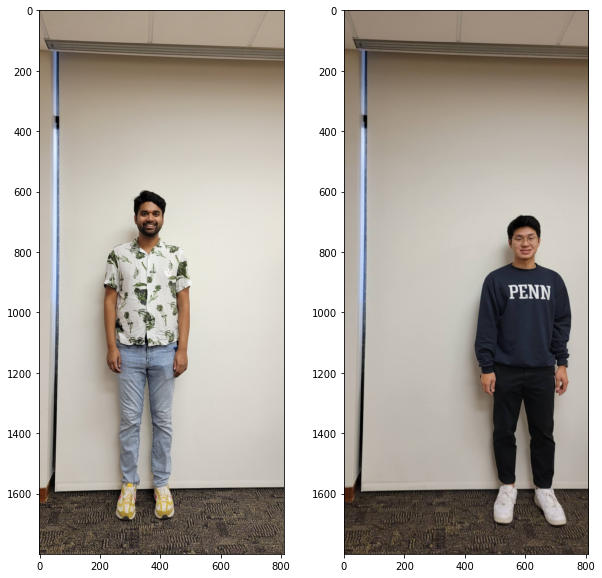

In [5]:
# left: source
# right: target

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB)) 
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

I used Microsoft Paint 3D software to create a mask of the source image, since we did not have one in the beginning of these trials.

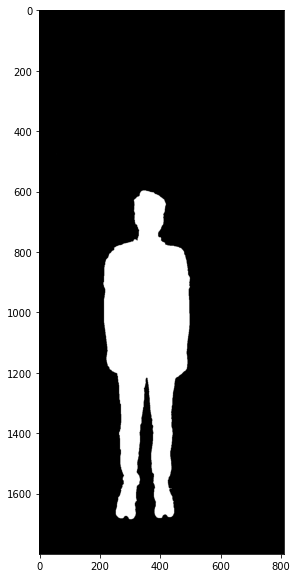

In [6]:
source_mask = cv2.imread('Images/perfect_mask.bmp')

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(source_mask, cv2.COLOR_BGR2RGB)) 

# Project Five - Poisson Image Editing

We will borrow a previous assignment from earlier this semester on Poisson Image Editing before moving forward to open-source libraries. Here, the final image is determined (or reconstructed) using a discrete Poisson equation. The discrete Poisson equation involves a discrete Laplacian operator which is a second order differential operator.

## Homework Code (Scratch)

In [7]:
def getIndexes(mask, targetH, targetW, offsetX=0, offsetY=0):
    """ 
    Creates indexes of replacement area in the target image, each pixel in the 
    replacement area gets index starting from 1, other pixels outside the 
    replacement area get 0.

    Args:
    - mask: SrcH * SrcW, logical mask of source image
    - targetH, targetW: int, height and width of target image
    - offsetX, offsetY: int, offset of source image origin in the target image

    Return:
    - indexes: targetH * targetW, indexes of replacement area in target image
    """
    # IMPLEMENT HERE
    # you might find numpy.meshgrid and numpy.arange useful
    

    #mask, targetH, targetW, offsetX, offsetY 

    # ------------------------------------------------------------------------------
    # Use meshgrid.
    # 1. Meshgrid splits the x and y coordinates.

    mask_H, mask_W = mask.shape
    

    mask_x, mask_y = np.meshgrid(np.arange(mask_W), np.arange(mask_H)) 
    #print(mask)
    #print(mask_x)
    #print(mask_y)

    # ------------------------------------------------------------------------------

    # 2. Go from source image coordinates to target image coordinates.
    # get indices where the mask value is 1 (i.e. greater than 0)
    target_img_x = mask_x[mask > 0]
    target_img_y = mask_y[mask > 0]


    # ------------------------------------------------------------------------------

    # 3. Setup indexes.
    # blank canvas of 0s
    indexes = np.zeros((targetH, targetW))
    # print(targetH)
    # print(targetW)
    # print(indexes)

    # ------------------------------------------------------------------------------

    # 4. Apply the offset.

    # Caution: x_offset is for the columns and y_offset is for the rows.
    # Caution: careful if offset goes beynod image edge.
    target_img_x += offsetX 
    target_img_y += offsetY 
    # print(target_img_x)
    # print(target_img_y)
    # ------------------------------------------------------------------------------

    # 5. Fill in the indexes from 1 to N.

    # indexes will have a shape same as the target image.
    # print(target_img_x.shape[0])

    indexes[target_img_y, target_img_x] = np.arange(1, target_img_x.shape[0] + 1)
    
    return indexes

In [8]:
def getCoefficientMatrix(indexes):
    """
    Constructs the coefficient matrix (A in Ax=b)
    
    Args: 
    - indexes: targetH * targetW, indexes of replacement area in target image
    
    Return:
    - A: N * N(N is max index), a matrix corresponds to laplacian kernel, 4 on the diagonal and -1 for each neighbor
    """
    # IMPLEMENT HERE

    # sparse matrix
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
    A = sparse.csr_matrix((int(np.amax(indexes)), int(np.amax(indexes))), dtype=np.int8)
    A.setdiag(4, k = 0) # 4 on the diagonal

    # meshgrid
    indexes_H, indexes_W = indexes.shape
    indexes_x, indexes_y = np.meshgrid(np.arange(indexes_W), np.arange(indexes_H))
    m, n = np.nonzero(indexes)

    # We create the coefficient matrix and put all 4s in the middle diagonal
    # np.eye - Return a 2-D array with ones on the diagonal and zeros elsewhere.
    # A = 4 * np.eye(indexes_H) # size N;  4 * 1 
    
    # retrieve x and y coordinates
    # x, y are the coordinates for each indexed pixels (non-zero) in the meshgrid.
    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]
    

    # ------------------------------------------------------------------------------
    # -1 for each neighbor

    # We want to get the meshgrid coordinates of all the neighbors of each indexed pixel inside the mask.

    # find coordinates of neighbors
    y_neighbor = np.arange(len(m))

    # ------------------------------------------------------------------------------
    # LEFT NEIGHBORS
    left_y = y
    left_x = x - 1 # shift by -1
    # Get the values from indexes for the left neighbor of each indexed pixel.
    left_neighbor = indexes[left_y, left_x] # check if neighbor is part of the mask

    # Get the coordinates for each neighbor (that is within the mask) to place into matrix A.
    left_y_neighbor = y_neighbor[left_neighbor > 0]
    left_x_neighbor = (left_neighbor[left_y_neighbor] - 1).astype(int)

    # ------------------------------------------------------------------------------
    # RIGHT NEIGHBORS
    right_y = y
    right_x = x + 1 # shift by +1

    right_neighbor = indexes[right_y, right_x] 
    right_y_neighbor = y_neighbor[right_neighbor > 0]
    right_x_neighbor = (right_neighbor[right_y_neighbor] - 1).astype(int)

    # ------------------------------------------------------------------------------
    # UP NEIGHBORS
    up_y = y - 1 # shift by -1
    up_x = x
    up_neighbor = indexes[up_y, up_x]
    up_y_neighbor = y_neighbor[up_neighbor > 0]
    up_x_neighbor = (up_neighbor[up_y_neighbor] - 1).astype(int)

    # ------------------------------------------------------------------------------
    # DOWN NEIGHBORS

    down_y = y + 1 # shift by +1
    down_x = x
    down_neighbor = indexes[down_y, down_x]
    down_y_neighbor = y_neighbor[down_neighbor > 0]
    down_x_neighbor = (down_neighbor[down_y_neighbor] - 1).astype(int)


    # Insert -1 for the neighbor positions in the coefficient matrix
    # Meshgrid power.
    A[left_y_neighbor, left_x_neighbor] = -1
    A[right_y_neighbor, right_x_neighbor] = -1
    A[up_y_neighbor, up_x_neighbor] = -1
    A[down_y_neighbor, down_x_neighbor] = -1

    return A

In [9]:
def getSolutionVect(indexes, source, target, offsetX, offsetY):
    """
    Constructs the target solution vector (b in Ax=b) 
    
    Args:
    - indexes:  targetH * targetW, indexes of replacement area in target image
    - source, target: source and target image
    - offsetX, offsetY: int, offset of source image origin in the target image

    Returns:
    - solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # you might find numpy.meshgrid and numpy.arange useful
    # ------------------------------------------------------------------------------    
    # 1. get Laplacian part of b from source image

    # from recitation
    laplacian = np.array([[0, -1, 0], 
                          [-1, 4, -1], 
                          [0, -1, 0]])
    source_laplacian = scipy.signal.convolve2d(source, laplacian, 'same')
    #print(source_laplacian)

    # ------------------------------------------------------------------------------
    # 2. get pixel part of b from target image

    # Laplacian part of b.
    # Subtract the offset to get back the pixel location in the source image.  

    # x and y are the coordinates of the masked pixels in indexes (meshgrid).
    y, x = np.nonzero(indexes)
    source_y = y - offsetY
    source_x = x - offsetX
    # We only want a subset of pixels of the region inside the mask from the source image.
    laplacian_b = source_laplacian[source_y, source_x]

    # b is an N x 1 vector.
    # print(laplacian_b)
  
    
    # ------------------------------------------------------------------------------  
    # Pixel part of b.
    # Create a coordinate line y_b.
    y_b = np.arange(x.shape[0])

    # We need to get the border neighbors and add them back to b side (if they are present).


    # ------------------------------------------------------------------------------      
    # Left neighbors.
    left_y = y
    left_x = x - 1
    left_neighbor = indexes[left_y, left_x]
    
    # For the left neighbor values that are 0 in indexes (outside the mask), get their coordinates.
    left_y_zero = left_y[left_neighbor == 0]
    left_x_zero = left_x[left_neighbor == 0]

    # Find the corresponding value in the target image for the neighbors that are 0 in indexes (outside the mask).
    left_val = target[left_y_zero, left_x_zero]
    left_b = np.zeros(x.shape[0])

    # y_b[left_neighbor == 0] is position along y_b where neighbor is 0 in indexes. We want to add the neighbor back at this position in b.
    # In left_b at position [y_b[left_neighbor == 0]] we store in left_val to add this to the corresponding indexed pixel in the mask.
    left_b[y_b[left_neighbor == 0]] = left_val


    # ------------------------------------------------------------------------------   
    # Right neighbors.
    right_y = y
    right_x = x + 1
    right_neighbor = indexes[right_y, right_x]
    
    # For the left neighbor values that are 0 in indexes (outside the mask), get their coordinates.
    right_y_zero = right_y[right_neighbor == 0]
    right_x_zero = right_x[right_neighbor == 0]

    # Find the corresponding value in the target image for the neighbors that are 0 in indexes (outside the mask).
    right_val = target[right_y_zero, right_x_zero]
    right_b = np.zeros(x.shape[0])

    right_b[y_b[right_neighbor == 0]] = right_val

    # ------------------------------------------------------------------------------   
    # Up neighbors.
    up_y = y - 1
    up_x = x 
    up_neighbor = indexes[up_y, up_x]
    
    # For the left neighbor values that are 0 in indexes (outside the mask), get their coordinates.
    up_y_zero = up_y[up_neighbor == 0]
    up_x_zero = up_x[up_neighbor == 0]

    # Find the corresponding value in the target image for the neighbors that are 0 in indexes (outside the mask).
    up_val = target[up_y_zero, up_x_zero]
    up_b = np.zeros(x.shape[0])

    up_b[y_b[up_neighbor == 0]] = up_val
    
    # ------------------------------------------------------------------------------   
    # Down neighbors.
    down_y = y + 1
    down_x = x 
    down_neighbor = indexes[down_y, down_x]
    
    # For the left neighbor values that are 0 in indexes (outside the mask), get their coordinates.
    down_y_zero = down_y[down_neighbor == 0]
    down_x_zero = down_x[down_neighbor == 0]

    # Find the corresponding value in the target image for the neighbors that are 0 in indexes (outside the mask).
    down_val = target[down_y_zero, down_x_zero]
    down_b = np.zeros(x.shape[0])

    down_b[y_b[down_neighbor == 0]] = down_val

    # ------------------------------------------------------------------------------      
    # 3. add two parts together to get b
    b = laplacian_b + left_b + right_b + up_b + down_b


    return b

In [10]:
def solveEqu(A, b):
    """
    Solve the equation Ax = b to get replacement pixels x in the replacement area
    Note: A is a sparse matrix, so we need to use corresponding function to solve it

    Args:
    - A: Laplacian coefficient matrix
    - b: target solution vector

    Returns:
    - x: solution of Ax = b
    """
    # IMPLEMENT HERE
    # you may find scipy.sparse.linalg.spsolve useful to solve equation

    x = scipy.sparse.linalg.spsolve(A,b)

    return x

In [11]:
def reconstructImg(indexes, red, green, blue, target):
    """
    Reconstruct the target image with new red, green, blue channel values in the 
    indexes area

    Args:
    - indexes: targetH * targetW, indexes of replacement area in target image
    - red, green, blue: 1 x N, three chanels for replacement pixel values
    - target: target image
    
    Returns:
    - resultImg: reconstructed target image with poisson editing
    """
    # IMPLEMENT HERE
    # 1. get nonzero component in indexes

    # x and y are the coordinates of the masked pixels in indexes (meshgrid).
    y, x = np.nonzero(indexes)

    # 2. stack three channels together with numpy dstack

    # dstack: Stack arrays in sequence depth wise (along third axis).
    # red, green, blue: 1 x N, three chanels for replacement pixel values
    stack = np.dstack((red, green, blue))
    # print(stack)

    # 3. copy new pixels in the indexes area to the target image
    target[y, x] = stack[0]
    # print(target)
    
    return target
    #return resultImg

In [12]:
"""
Function (do not modify)
"""
def seamlessCloningPoisson(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    
    Args:
    - sourceImg, targetImg: source and targe image
    - mask: logical mask of source image
    - offsetX, offsetY: offset of source image origin in the target image
    
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

## Trial One: Initializing Offsets


Arguments: offsetX = 0, offsetY = 0 

source size:  (1800, 810, 3)
source mask size:  (1800, 810)
target size:  (1800, 810, 3)


/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


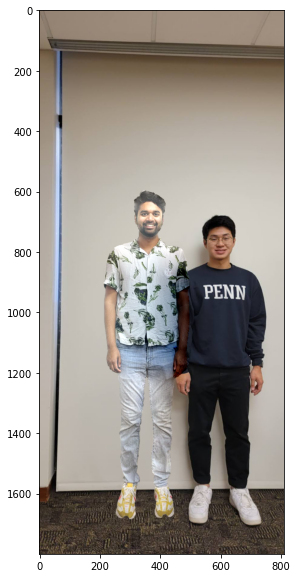

In [13]:
# setting up
src_path = 'Images/source.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='Images/target.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
mask_path = 'Images/perfect_mask.bmp'
src_mask = np.array(Image.open(mask_path).convert('L')) > 0

# note the shapes
print('source size: ', src.shape)
print('source mask size: ', src_mask.shape)
print('target size: ', target.shape)

# define offsets
# indicates the position of the replacement pixels in the target image
offsetX = 0
offsetY = 0
 
result = seamlessCloningPoisson(src, target, src_mask, offsetX, offsetY)

plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.show()

Amar appears very ghostly/transparent. Image needs to be recentered.

## Trial Two: Shifting Left

Arguments: offsetX = -55, offsetY = 0

source size:  (1800, 810, 3)
source mask size:  (1800, 810)
target size:  (1800, 810, 3)


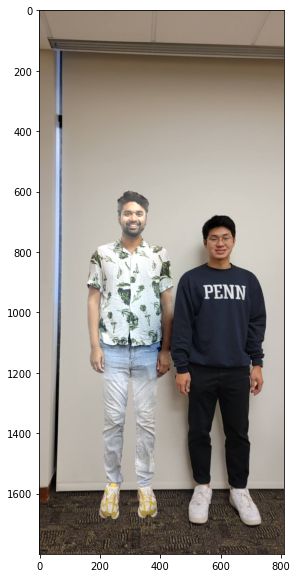

In [14]:
# setting up
src_path = 'Images/source.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='Images/target.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
mask_path = 'Images/perfect_mask.bmp'
src_mask = np.array(Image.open(mask_path).convert('L')) > 0

# note the shapes
print('source size: ', src.shape)
print('source mask size: ', src_mask.shape)
print('target size: ', target.shape)

# define offsets
# indicates the position of the replacement pixels in the target image
offsetX = -55
offsetY = 0
 
result = seamlessCloningPoisson(src, target, src_mask, offsetX, offsetY)

plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.show()

This appears to be the max in which I can move Amar to the left.

## Trial Three: Error

Arguments: offsetX = -60, offsetY = 0

**Note: Intended to run into error.**

In [15]:
# setting up
src_path = 'Images/source.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='Images/target.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
mask_path = 'Images/perfect_mask.bmp'
src_mask = np.array(Image.open(mask_path).convert('L')) > 0

# note the shapes
print('source size: ', src.shape)
print('source mask size: ', src_mask.shape)
print('target size: ', target.shape)

# define offsets
# indicates the position of the replacement pixels in the target image
offsetX = -60
offsetY = 0
 
result = seamlessCloningPoisson(src, target, src_mask, offsetX, offsetY)

plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.show()

source size:  (1800, 810, 3)
source mask size:  (1800, 810)
target size:  (1800, 810, 3)


IndexError: ignored

# OpenCV

Let's try OpenCV's built-in seamless cloning function. <br> 

Resources:
*   https://docs.opencv.org/3.4/df/da0/group__photo__clone.html
*   https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/ 



## Sample Images

<class 'numpy.ndarray'>
source size:  (194, 300, 3)
source mask size:  (194, 300, 3)
target size:  (561, 1000, 3)


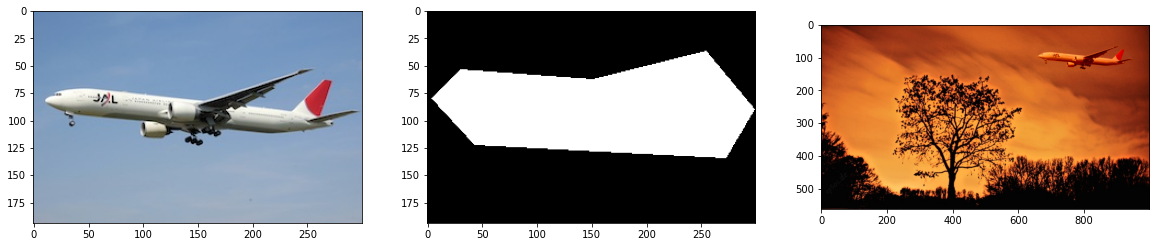

In [16]:
# Read images
src = cv2.imread("data/airplane.jpg")
target = cv2.imread("data/sky.jpg")

# Create a rough mask around the airplane (source)
src_mask = np.zeros(src.shape, src.dtype)
poly = np.array([ [4,80], [30,54], [151,63], [254,37], [298,90], [272,134], [43,122] ], np.int32)
src_mask = cv2.fillPoly(src_mask, [poly], (255, 255, 255))

print(type(src))

print('source size: ', src.shape)
print('source mask size: ', src_mask.shape)
print('target size: ', target.shape)

# This is where the CENTER of the airplane will be placed
center = (800,100)

output = cv2.seamlessClone(src, target, src_mask, center, cv2.NORMAL_CLONE)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(src_mask, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

There are some differences compared to the homework code. The first difference is that the source image and target image are different sizes. The second difference is that the mask is not perfect, but rather created in a way to capture the general shape and size of the plane.

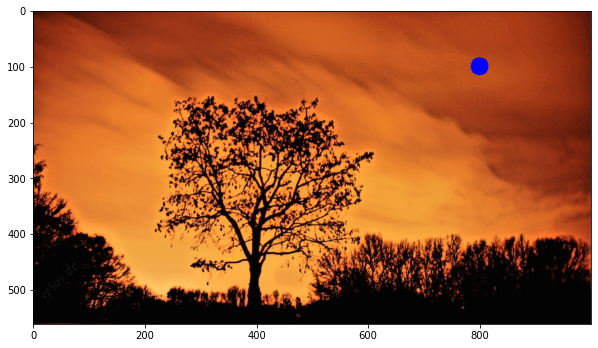

In [17]:
target_dot = target.copy()
target_dot = cv2.circle(target_dot, center, radius=1, color=(255, 0, 0), thickness=30)

fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_dot, cv2.COLOR_BGR2RGB))

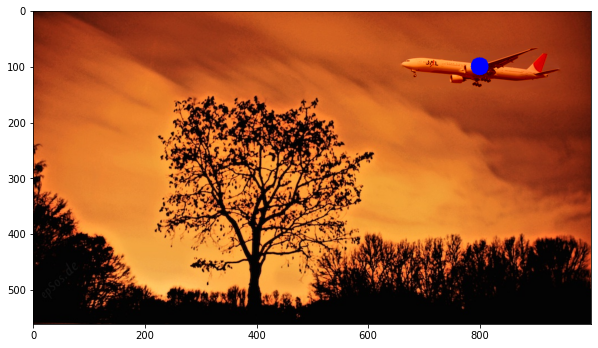

In [18]:
output_dot = output.copy()
output_dot = cv2.circle(output_dot, center, radius=1, color=(255, 0, 0), thickness=30)

fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_dot, cv2.COLOR_BGR2RGB))

The center parameter of ***seamlessClone*** places coordinates (show as blue dot) on the target image, which represent where the source image will be. The object in the source image is centered on the point based on the shape of the object in the mask. 

## Trial One: Source and Target have the Same Dimensions

In [19]:
src = cv2.imread('Images/source.jpg')
target = cv2.imread('Images/target.jpg')
src_mask = cv2.imread('Images/perfect_mask.bmp')

print('source size: ', src.shape)
print('source mask size: ', src_mask.shape)
print('target size: ', target.shape)

source size:  (1800, 810, 3)
source mask size:  (1800, 810, 3)
target size:  (1800, 810, 3)


Center: (405, 900)

center:  (405, 900)


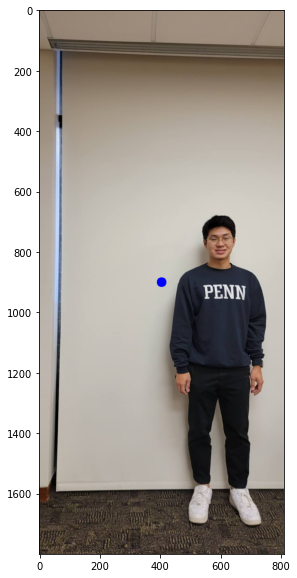

In [20]:
# manually determined center
center = (int(target.shape[1]/2), int(target.shape[0]/2)) # center of the target image
print('center: ', center)


target_dot = target.copy()
target_dot = cv2.circle(target_dot, center, radius=1, color=(255, 0, 0), thickness=30)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_dot, cv2.COLOR_BGR2RGB))

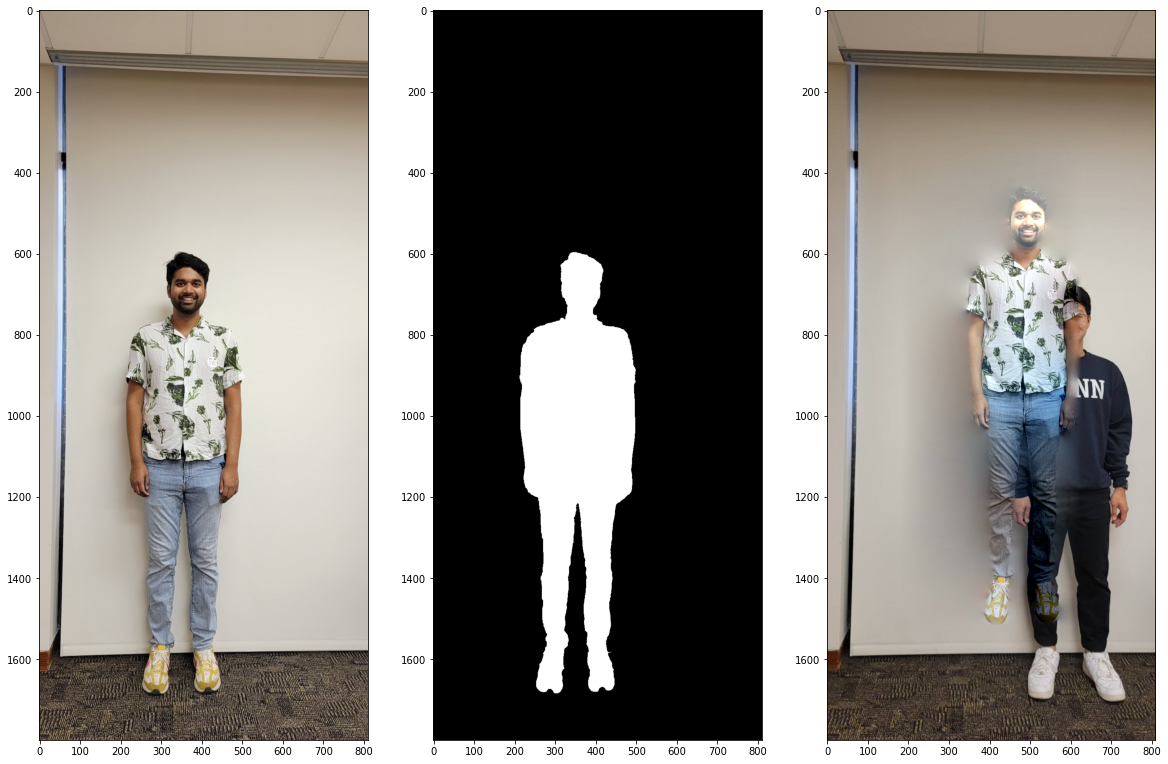

In [21]:
output = cv2.seamlessClone(src, target, src_mask, center, cv2.NORMAL_CLONE)


fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(src_mask, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

Center: (230, 1100) 

center:  (230, 1100)


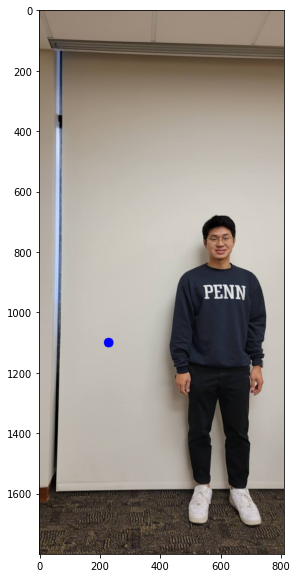

In [22]:
# manually determined center
center = (230, 1100)
print('center: ', center)

target_dot = target.copy()
target_dot = cv2.circle(target_dot, center, radius=1, color=(255, 0, 0), thickness=30)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_dot, cv2.COLOR_BGR2RGB))

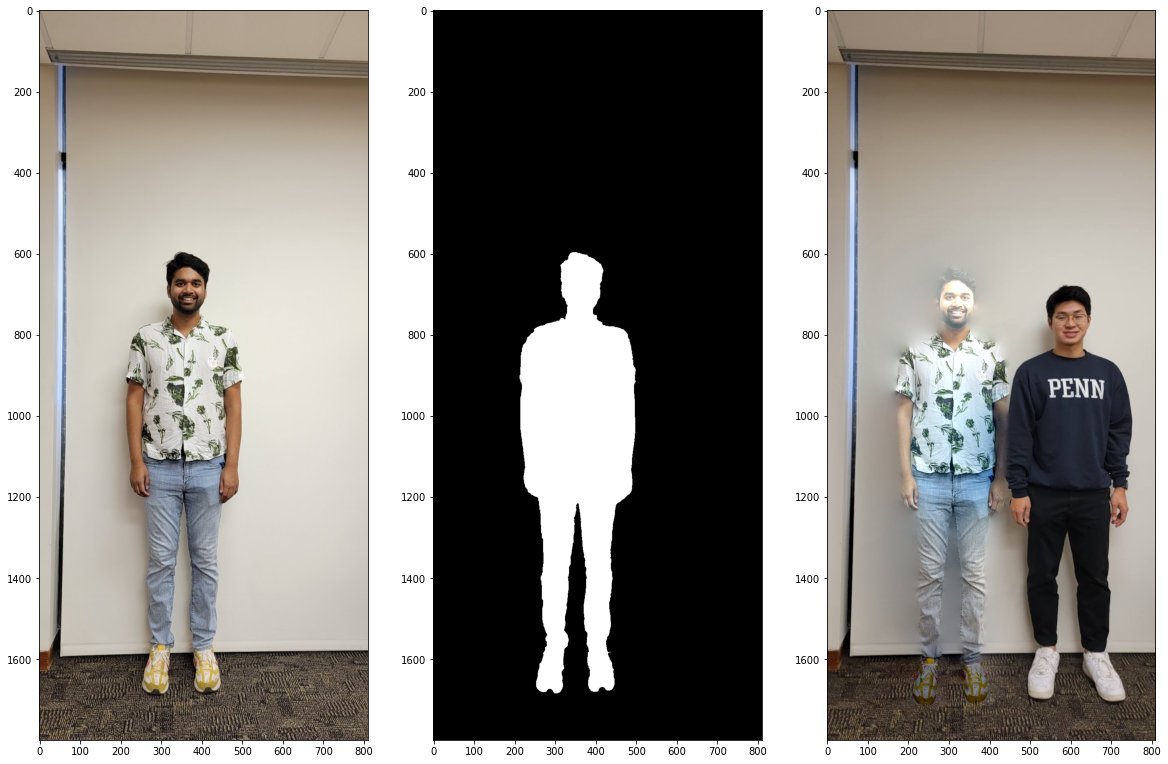

In [23]:
output = cv2.seamlessClone(src, target, src_mask, center, cv2.NORMAL_CLONE)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(src_mask, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

The mask is perfect and is tight aroudn the object. Yet, it produces this ghostly figure. Also, the center cannot be shifted anymore to the left.


Center: (220, 1100) <br>
**Note: Intended to run into error.**

center:  (220, 1100)


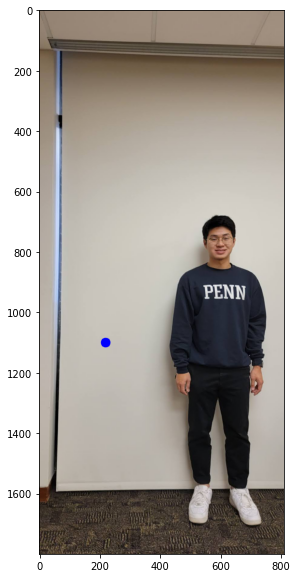

In [24]:
# manually determined center
center = (220, 1100)
print('center: ', center)

target_dot = target.copy()
target_dot = cv2.circle(target_dot, center, radius=1, color=(255, 0, 0), thickness=30)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_dot, cv2.COLOR_BGR2RGB))

In [25]:
output = cv2.seamlessClone(src, target, src_mask, center, cv2.NORMAL_CLONE)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(src_mask, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

error: ignored

## Trial Two: Cropping Source Image and Mask

In [26]:
src = cv2.imread('Images/source.jpg')
target = cv2.imread('Images/target.jpg')
src_mask = cv2.imread('Images/perfect_mask.bmp')

print('source size: ', src.shape)
print('source mask size: ', src_mask.shape)
print('target size: ', target.shape)

source size:  (1800, 810, 3)
source mask size:  (1800, 810, 3)
target size:  (1800, 810, 3)


We crop the source image. We leave a little bit of space around Amar, so the cropping will not be as tight. This is all done manually.

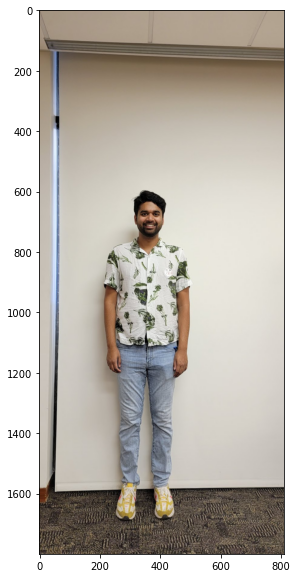

In [27]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))

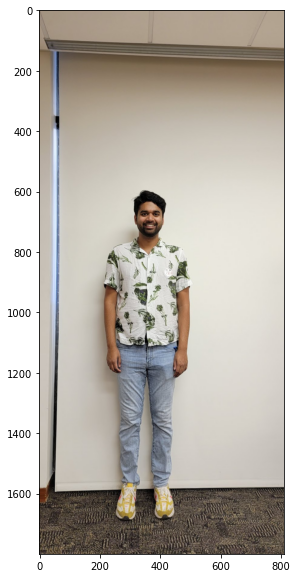

In [28]:
src = cv2.imread('Images/source.jpg')
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))

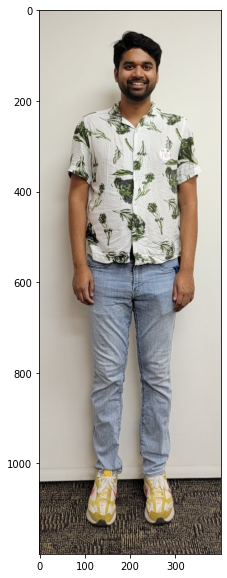

In [29]:
# slicing np array to indicate which part of image we want
cropped_src = src[550:1750, 150:550] #  manually configured
 
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cropped_src, cv2.COLOR_BGR2RGB))

We perform similar operations with the source mask, cropping the same region as the source image.

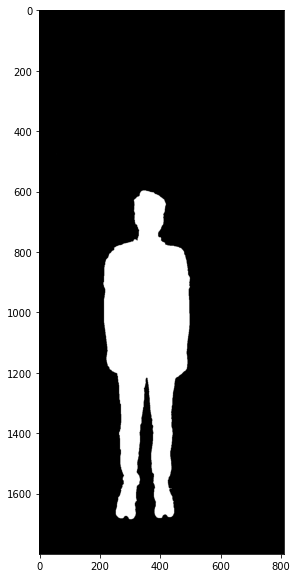

In [30]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(src_mask, cv2.COLOR_BGR2RGB))

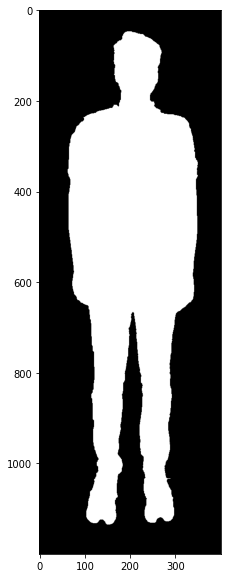

In [31]:
# slicing np array to indicate which part of image we want
cropped_src_mask = src_mask[550:1750, 150:550] # same as source image
 
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cropped_src_mask, cv2.COLOR_BGR2RGB))

In [32]:
# note the new shapes
print('source size: ', cropped_src.shape)
print('source mask size: ', cropped_src_mask.shape)
print('target size: ', target.shape)

source size:  (1200, 400, 3)
source mask size:  (1200, 400, 3)
target size:  (1800, 810, 3)


We perform seamless cloning to stitch the source object (Amar) onto the target image.

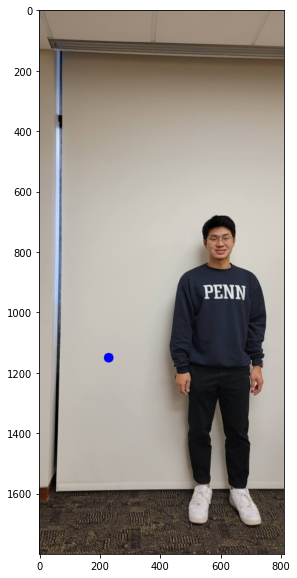

In [33]:
# manually adjusted
center = (230, 1150)

target_dot = target.copy()
target_dot = cv2.circle(target_dot, center, radius=1, color=(255, 0, 0), thickness=30)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_dot, cv2.COLOR_BGR2RGB))

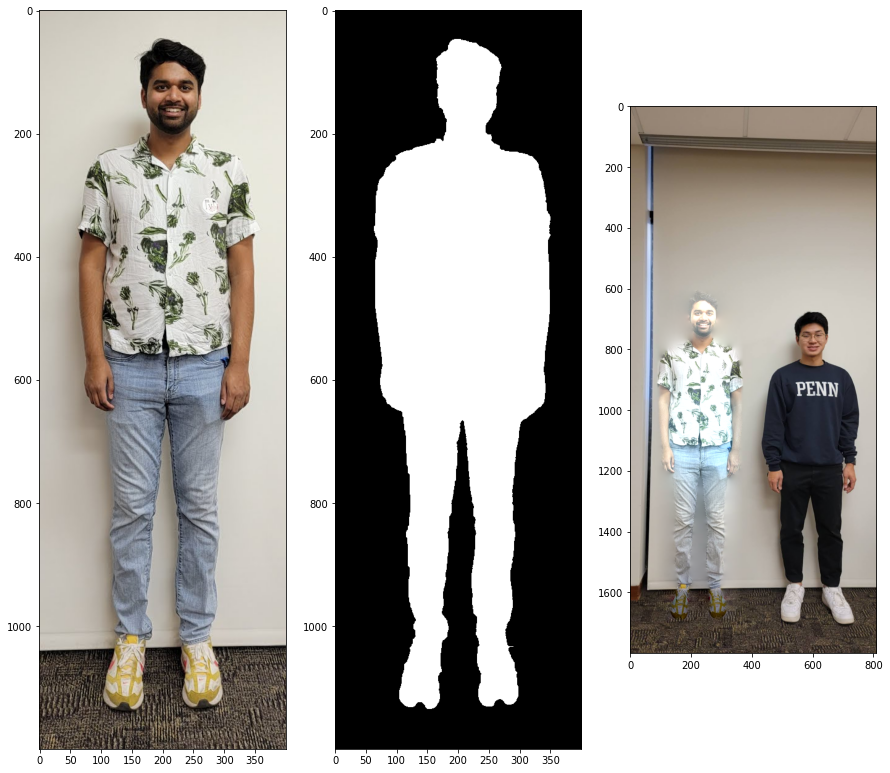

In [34]:
output = cv2.seamlessClone(cropped_src, target, cropped_src_mask, center, cv2.NORMAL_CLONE)
# output = cv2.circle(output, center, radius=1, color=(0, 0, 255), thickness=30)


fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cropped_src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(cropped_src_mask, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

It turns out that if the mask is completely tight the border gradient is then artificially interpreted as null. That is why it ignores it completely and produces ghosts.

Using a larger mask by dilating the original mask using morphological operations and therefore including some background is thus the solution.

https://stackoverflow.com/questions/49008854/using-seamlessclone-in-opencv-python-produces-image-with-ghost-objects

Create a filled rectangle around person mask. We will use contoue method.

## Trial Three: Larger Rectangular Mask

We test out a rectangular bounding box around our newly cropped source mask. 

In [35]:
# Generate contours based on our mask - 
# Tedious but OpenCV gives error messages regarding correct types

im = cv2.cvtColor(cropped_src_mask, cv2.COLOR_BGR2GRAY)
_, im_t = cv2.threshold(im, 160, 255, cv2.THRESH_BINARY) # binarize
contours, _ = cv2.findContours(im_t, 1, 2)

# make copy 
cropped_src_mask_rect = cropped_src_mask.copy()
x, y, w, h = cv2.boundingRect(contours[0])

# create rectanglular white box over image
cropped_src_mask_rect = cv2.rectangle(cropped_src_mask_rect,(x,y), (x+w,y+h), (255,255,255), -1) # new mask

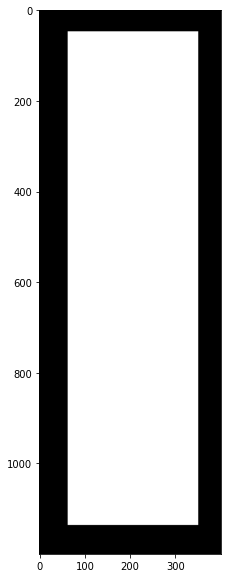

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cropped_src_mask_rect, cv2.COLOR_BGR2RGB))

In [37]:
print('source size: ', cropped_src.shape)
print('source mask size: ', cropped_src_mask_rect.shape)
print('target size: ', target.shape)

# same as before
center = (230, 1150) 

source size:  (1200, 400, 3)
source mask size:  (1200, 400, 3)
target size:  (1800, 810, 3)


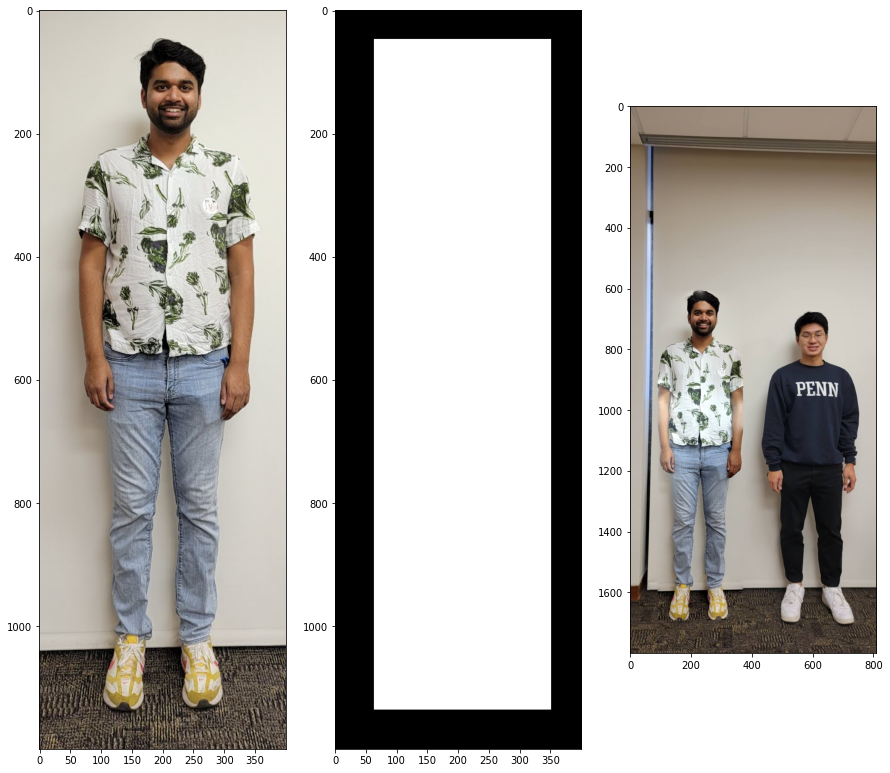

In [38]:
output = cv2.seamlessClone(cropped_src, target, cropped_src_mask_rect, center, cv2.NORMAL_CLONE)

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cropped_src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(cropped_src_mask_rect, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

## Trial Four: Different Color Mask

In [39]:
# change black pixels to gray

gray_cropped_mask_rect = cropped_src_mask_rect.copy()

gray_cropped_mask_rect[np.where((gray_cropped_mask_rect==[0,0,0]).all(axis=2))] = (128,128,128)

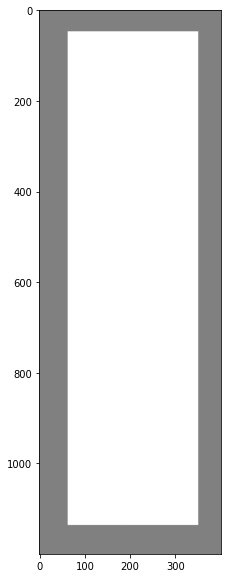

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(gray_cropped_mask_rect, cv2.COLOR_BGR2RGB))

In [41]:
print('source size: ', cropped_src.shape)
print('source mask size: ', gray_cropped_mask_rect.shape)
print('target size: ', target.shape)

# same as before
center = (230, 1150) 

source size:  (1200, 400, 3)
source mask size:  (1200, 400, 3)
target size:  (1800, 810, 3)


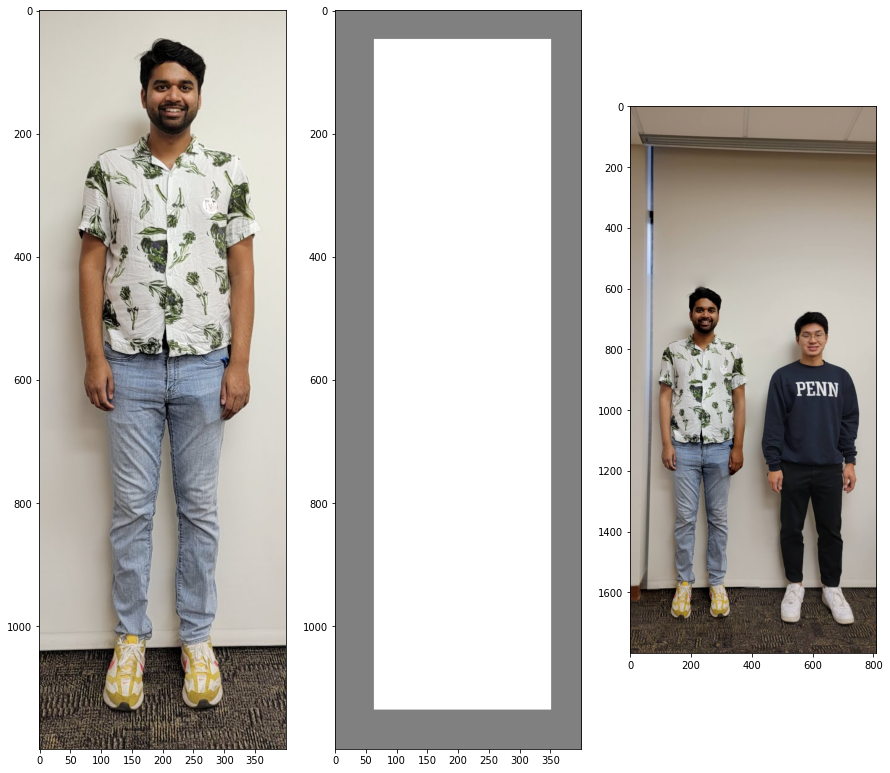

In [42]:
output = cv2.seamlessClone(cropped_src, target, gray_cropped_mask_rect, center, cv2.NORMAL_CLONE)

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cropped_src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(gray_cropped_mask_rect, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

# Compare Output with Ground Truth 

We used Adobe Photoshop software to stitch the source image onto the target image in the beginning of our project. We use this as our ground truth and we compare it with the output from the seamless cloning method.

In [43]:
ground_truth = cv2.imread('Images/groundtruth.jpeg')

Text(0.5, 1.0, 'Adobe Photoshop Output')

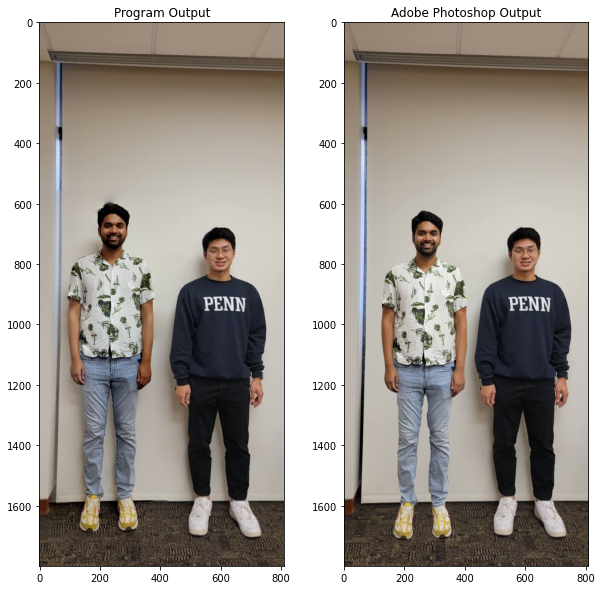

In [44]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Program Output")
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB))
plt.title("Adobe Photoshop Output")